In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/liar-fake-news-dataset/test.tsv
/kaggle/input/liar-fake-news-dataset/README
/kaggle/input/liar-fake-news-dataset/train.tsv
/kaggle/input/liar-fake-news-dataset/valid.tsv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/train.tsv', sep='\t', header=None)
test_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/test.tsv', sep='\t', header=None)
valid_df = pd.read_csv('/kaggle/input/liar-fake-news-dataset/valid.tsv', sep='\t', header=None)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [5]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [6]:
valid_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [8]:
train_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in train_df[1]] 
test_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in test_df[1]] 
valid_df['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in valid_df[1]] 

In [9]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,0
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,0
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,1
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,0
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,0


In [10]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview,1
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference,0
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.,0
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show,0
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video,0


In [11]:
valid_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,label
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News,0
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN,0
2,7891.json,false,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing,0
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article,0
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News,0


In [12]:
#Below function performs all the required data cleaning and preprocessing steps

def data_preprocessing(dataset):
  #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
  dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]] 
  #Dropping unwanted columns
  dataset = dataset.drop(labels=[0,1,8,9,10,11,12] ,axis=1)
  #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
  meta = []
  for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
  #Adding cleaned and combined metadata column to the dataset
  dataset[14] = meta
  dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns

  dataset = dataset.drop([2,3,4,5,6,7,13,14], axis=1) #dropping metadata columns, as we have merged them into a single column
  dataset.dropna() #Dropping if there are still any null values

  return dataset

In [15]:
train_df = data_preprocessing(train_df)
valid_df = data_preprocessing(valid_df)
test_df = data_preprocessing(test_df)

In [16]:
train_df.head()

,label,sentence
0,0,abortion dwayne-bohac State representative Tex...
1,0,"energy,history,job-accomplishments scott-surov..."
2,1,foreign-policy barack-obama President Illinois...
3,0,health-care blog-posting nan nan none a news r...
4,0,"economy,jobs charlie-crist nan Florida democra..."


In [17]:
train_df.isna().sum()

label       0
sentence    0
dtype: int64

In [18]:
test_df.isna().sum()

label       0
sentence    0
dtype: int64

In [19]:
valid_df.isna().sum()

label       0
sentence    0
dtype: int64

In [21]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [22]:
train_df['sentence']=train_df['sentence'].apply(lambda x:review_cleaning(x))
test_df['sentence']=test_df['sentence'].apply(lambda x:review_cleaning(x))
valid_df['sentence']=valid_df['sentence'].apply(lambda x:review_cleaning(x))

train_df.head()

,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting nan nan none a news rel...
4,0,economyjobs charliecrist nan florida democrat ...


In [23]:
stop = stopwords.words('english')
train_df['sentence'] = train_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_df['sentence'] = test_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
valid_df['sentence'] = valid_df['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_df.head()

,label,sentence
0,0,abortion dwaynebohac state representative texa...
1,0,energyhistoryjobaccomplishments scottsurovell ...
2,1,foreignpolicy barackobama president illinois d...
3,0,healthcare blogposting nan nan none news relea...
4,0,economyjobs charliecrist nan florida democrat ...


In [29]:
max_words = 5000
maxlen = 100
tokenizer0 = Tokenizer(num_words=max_words)
tokenizer0.fit_on_texts(train_df['sentence'])

tokenizer1 = Tokenizer(num_words=max_words)
tokenizer1.fit_on_texts(test_df['sentence'])

tokenizer2 = Tokenizer(num_words=max_words)
tokenizer2.fit_on_texts(valid_df['sentence'])

train_sequences = tokenizer0.texts_to_sequences(train_df['sentence'])
test_sequences = tokenizer1.texts_to_sequences(test_df['sentence'])
valid_sequences = tokenizer2.texts_to_sequences(valid_df['sentence'])

x_train = pad_sequences(train_sequences, maxlen=maxlen)
x_test = pad_sequences(test_sequences, maxlen=maxlen)
x_valid = pad_sequences(valid_sequences, maxlen=maxlen)

y_train = train_df['label']
y_train = pd.get_dummies(y_train)

y_test = test_df['label']
y_test = pd.get_dummies(y_test)

y_valid = valid_df['label']
y_valid = pd.get_dummies(y_valid)

# CNN

In [57]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense

In [168]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=maxlen))
model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [169]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [170]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 100, 64)           320000    
                                                                 
 conv1d_17 (Conv1D)          (None, 96, 32)            10272     
                                                                 
 global_max_pooling1d_16 (Gl  (None, 32)               0         
 obalMaxPooling1D)                                               
                                                                 
 flatten_12 (Flatten)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 64)                2112      
                                                                 
 dense_49 (Dense)            (None, 2)                 130       
                                                     

In [171]:
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
160/160 [==============================] - 9s 50ms/step - loss: 0.6398 - accuracy: 0.6461 - val_loss: 0.6343 - val_accuracy: 0.6674
Epoch 2/5
160/160 [==============================] - 3s 16ms/step - loss: 0.5663 - accuracy: 0.7094 - val_loss: 0.6671 - val_accuracy: 0.6059
Epoch 3/5
160/160 [==============================] - 2s 13ms/step - loss: 0.3735 - accuracy: 0.8479 - val_loss: 0.7834 - val_accuracy: 0.5787
Epoch 4/5
160/160 [==============================] - 2s 15ms/step - loss: 0.1377 - accuracy: 0.9623 - val_loss: 1.0801 - val_accuracy: 0.5319
Epoch 5/5
160/160 [==============================] - 1s 5ms/step - loss: 0.0317 - accuracy: 0.9942 - val_loss: 1.2552 - val_accuracy: 0.5693


In [172]:
y_pred0 = model.predict(x_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

40/40 [==============================] - 0s 2ms/step
Accuracy: 0.5651144435674822
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68       818
           1       0.36      0.30      0.33       449

    accuracy                           0.57      1267
   macro avg       0.51      0.50      0.50      1267
weighted avg       0.55      0.57      0.55      1267



In [173]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

array([[582, 236],
       [315, 134]])

In [174]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

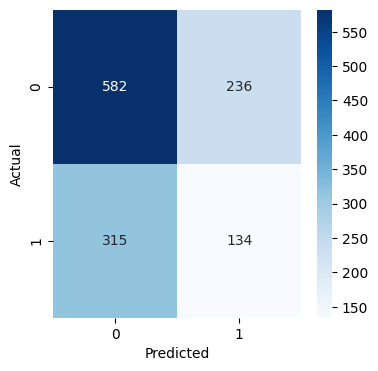

In [175]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# LSTM

In [204]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 64, input_length=maxlen))
model_lstm.add(LSTM(32,dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Flatten())
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(2, activation='sigmoid'))

In [205]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [206]:
model_lstm.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 100, 64)           320000    
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 flatten_17 (Flatten)        (None, 32)                0         
                                                                 
 dense_60 (Dense)            (None, 64)                2112      
                                                                 
 dense_61 (Dense)            (None, 2)                 130       
                                                                 
Total params: 334,658
Trainable params: 334,658
Non-trainable params: 0
_________________________________________________________________


In [207]:
model_lstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
160/160 [==============================] - 37s 213ms/step - loss: 0.6387 - accuracy: 0.6508 - val_loss: 0.6470 - val_accuracy: 0.6674
Epoch 2/5
160/160 [==============================] - 30s 186ms/step - loss: 0.5586 - accuracy: 0.7077 - val_loss: 0.6939 - val_accuracy: 0.6160
Epoch 3/5
160/160 [==============================] - 28s 175ms/step - loss: 0.4885 - accuracy: 0.7619 - val_loss: 0.8170 - val_accuracy: 0.5592
Epoch 4/5
160/160 [==============================] - 28s 174ms/step - loss: 0.4187 - accuracy: 0.8073 - val_loss: 0.8862 - val_accuracy: 0.5234
Epoch 5/5
160/160 [==============================] - 28s 174ms/step - loss: 0.3598 - accuracy: 0.8402 - val_loss: 0.9944 - val_accuracy: 0.5530


In [208]:
y_pred1 = model_lstm.predict(x_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

40/40 [==============================] - 1s 24ms/step
Accuracy: 0.5548539857932123
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       818
           1       0.35      0.30      0.32       449

    accuracy                           0.55      1267
   macro avg       0.50      0.50      0.50      1267
weighted avg       0.54      0.55      0.55      1267



In [209]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[568, 250],
       [314, 135]])

In [210]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

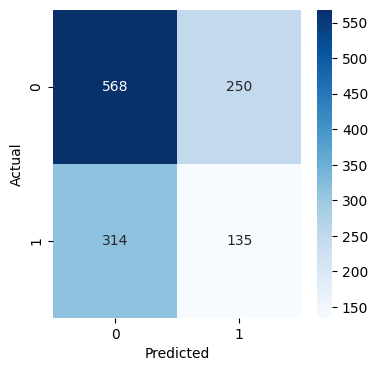

In [211]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# Bi-Lstm

In [212]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 64, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Flatten())
model_bilstm.add(Dense(64, activation='relu'))
model_bilstm.add(Dense(2, activation='sigmoid'))

In [213]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [214]:
model_bilstm.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 100, 64)           320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dense_63 (Dense)            (None, 2)                 130       
                                                                 
Total params: 349,122
Trainable params: 349,122
Non-trainable params: 0
_______________________________________________

In [215]:
model_bilstm.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_valid, y_valid))

Epoch 1/5
160/160 [==============================] - 62s 363ms/step - loss: 0.6389 - accuracy: 0.6465 - val_loss: 0.6377 - val_accuracy: 0.6682
Epoch 2/5
160/160 [==============================] - 52s 327ms/step - loss: 0.5585 - accuracy: 0.7072 - val_loss: 0.7211 - val_accuracy: 0.5997
Epoch 3/5
160/160 [==============================] - 51s 320ms/step - loss: 0.4827 - accuracy: 0.7606 - val_loss: 0.8065 - val_accuracy: 0.5343
Epoch 4/5
160/160 [==============================] - 50s 313ms/step - loss: 0.4081 - accuracy: 0.8083 - val_loss: 0.8929 - val_accuracy: 0.5382
Epoch 5/5
160/160 [==============================] - 52s 323ms/step - loss: 0.3502 - accuracy: 0.8431 - val_loss: 1.1723 - val_accuracy: 0.5312


In [216]:
y_pred2 = model_bilstm.predict(x_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred2))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred2))

40/40 [==============================] - 2s 49ms/step
Accuracy: 0.5367008681925809
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       818
           1       0.35      0.35      0.35       449

    accuracy                           0.54      1267
   macro avg       0.49      0.49      0.49      1267
weighted avg       0.54      0.54      0.54      1267



In [217]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[523, 295],
       [292, 157]])

In [218]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

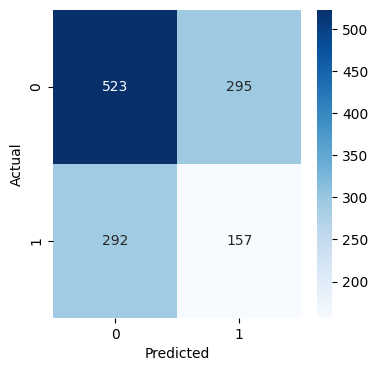

In [219]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')